# Look back XGBoost stock prediction

In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import math
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 


In [4]:
df = pd.read_csv('../data/upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.sort_index()

training_data_len = math.ceil(len(df) * .8)

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(1592, 1) (397, 1)


In [5]:
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data.values
dataset_test = np.reshape(dataset_test, (-1,1))

dataset_test.shape, dataset_train.shape

((397, 1), (1592, 1))

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[[0.45640217]
 [0.46062803]
 [0.44832069]
 [0.43868547]
 [0.44598557]]
[0.84454818] [0.86667668] [0.82659367] [0.80725839] [0.70619221]


In [7]:
# Create sequences and labels for training data
sequence_length = 50 # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
	X_train.append(scaled_train[i:i+sequence_length])
	y_train.append(scaled_train[i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).float()
y_train = torch.tensor(y_train, dtype=torch.float32).float()
X_train.shape,y_train.shape


(torch.Size([1542, 50, 1]), torch.Size([1542, 1]))

In [14]:
# Create sequences and labels for training data
sequence_length = 50 # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
	X_test.append(scaled_test[i:i+sequence_length])
	y_test.append(scaled_test[i+sequence_length])

X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32).float().squeeze()
y_test = torch.tensor(y_test, dtype=torch.float32).float()
X_test.shape,y_test.shape


(torch.Size([347, 50]), torch.Size([347, 1]))

## Modelling

In [9]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train.squeeze(), y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.057094608
Root Mean squared Error - RMSE : 0.07568246471424274


In [16]:
with torch.no_grad():
    t = scaler.inverse_transform(y_test)
    tp = scaler.inverse_transform(predictions.reshape(-1, 1))
    

In [24]:
math.sqrt(mean_squared_error(t, tp))

200.72583615414294

In [23]:
with torch.no_grad():
    tpreds = my_model.predict(X_train.squeeze())
    tr = scaler.inverse_transform(y_train)
    trp = scaler.inverse_transform(tpreds.reshape(-1, 1))
    print(math.sqrt(mean_squared_error(tr, trp)))
    

3.5651031645488147


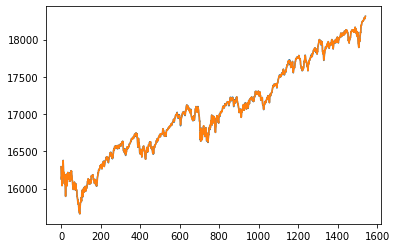

In [27]:
import matplotlib.pyplot as plt

plt.plot(tr)
plt.plot(trp)

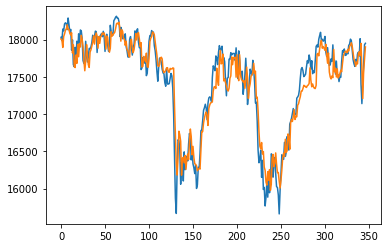

In [28]:
plt.plot(t)
plt.plot(tp)
